In [1]:
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload 1
%aimport pygenesig.validation
%aimport pygenesig.gini
%aimport pygenesig.bioqc
%aimport pygenesig.perfmeasures
%matplotlib inline

from pygenesig.validation import * 
from pygenesig.gini import * 
from pygenesig.bioqc import * 
from pygenesig.limma import * 
import pygenesig.perfmeasures as pm
import numpy as np
import pandas as pd

import seaborn as sns
from pylab import * 

# Signature Generation and Validation on GTEx with gini-index. 
In this document, we generate and test the signatures ** on the same dataset **. The final result might therefore not be representative. This document is to demonstrate the ease-of-use of *pygenesig*. 

## Load a dataset
Expression Matrix + Tissue Labels

In [9]:
expr = np.load("../data/gtex/exprs.npy")
target = np.genfromtxt("../data/gtex/target.csv", delimiter=",", dtype=str)
covariates = pd.read_csv("../data/gtex/covariates.csv", index_col=0)

In [14]:
covariates = covariates[["RIN", "Gender"]]

## Make Signatures

In [15]:
fold_change=100

In [16]:
sg = LimmaSignatureGenerator(expr, target, covariates, fold_change=fold_change)

In [17]:
signatures = sg.mk_signatures()

### store signatures as GMT
first, translate to gene symbols

In [30]:
gene_symbols = np.genfromtxt("../data/gtex/gene_symbols.csv", delimiter=",", dtype=str)
gene_symbols = gene_symbols[:, 1]

In [31]:
gene_signatures = {
    tissue: set([gene_symbols[i] for i in genes]) for tissue, genes in signatures.items()
}

In [32]:
write_gmt(gene_signatures, "../data/gtex/gtex_ngs_limma_{}.gmt".format(fold_change),
          description="Derived from GTEx dataset with pygenesig and limma. fold_change={}".format(fold_change))

## Test Signatures
(You could also load a different dataset, e.g. from a different species here)

In [22]:
st = BioQCSignatureTester(expr, target)

In [23]:
actual, predicted = st.test_signatures(signatures)

In [24]:
confmat = st.confusion_matrix(signatures, actual, predicted)

In [25]:
sig_labels = st.sort_signatures(signatures)

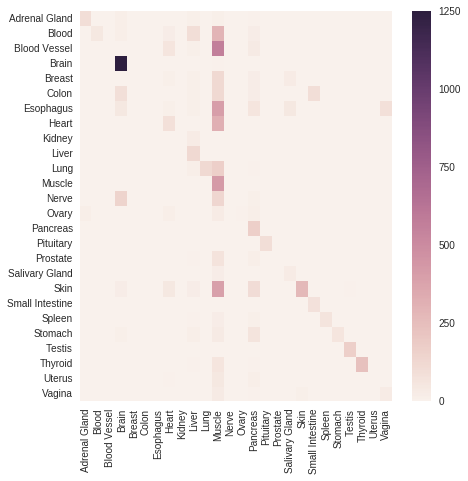

In [26]:
fig, ax = subplots(figsize=(7, 7))
sns.heatmap(confmat, ax=ax, xticklabels=sig_labels, yticklabels=sig_labels)


Binary classifications performance per signatures

In [11]:
print("Tissue", "Sens", "Spec", "MCC")
for i, sig in enumerate(sig_labels):
    TP = confmat[i, i]
    FN = np.sum(confmat[i, :]) - TP
    FP = np.sum(confmat[:, i]) - TP
    TN = np.sum(confmat) - TP - FN - FP
    m = (TP, FN, FP, TN)
    print(sig, pm.sens(*m), pm.spec(*m), pm.mcc(*m))

Tissue Sens Spec MCC
Adipose Tissue 0.649913344887 0.984146955209 0.689080668795
Adrenal Gland 1.0 1.0 1.0
Blood 0.919765166341 0.965061143 0.746200445951
Blood Vessel 0.882438316401 0.99821337417 0.923372479993
Brain 1.0 0.999587118084 0.99860448652
Breast 0.289719626168 1.0 0.533400512698
Colon 0.565217391304 0.997310513447 0.706730730413
Esophagus 0.52332361516 0.988391376451 0.635968464244
Heart 1.0 0.997904597559 0.978958933014
Kidney 1.0 1.0 1.0
Liver 1.0 0.999881037354 0.995765381692
Lung 0.984375 1.0 0.991854577262
Muscle 1.0 0.995799876467 0.960641338935
Nerve 1.0 0.998418683858 0.978506039359
Ovary 1.0 0.999881347888 0.994825852595
Pancreas 1.0 0.999880296864 0.997029106558
Pituitary 1.0 1.0 1.0
Prostate 0.905660377358 1.0 0.951097218837
Salivary Gland 0.929824561404 0.99196976854 0.635853186811
Skin 0.82808988764 0.999607072692 0.89907639506
Small Intestine 0.954545454545 0.982576745289 0.584355330538
Spleen 1.0 0.992281201758 0.781431113853
Stomach 0.765625 0.9997599904 0.8